In [154]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
import shap
from matplotlib import pyplot as plt

In [155]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
sns.set_style('whitegrid')
from os import listdir
from os.path import isfile, join
from pandas_datareader import data
import yfinance as yf
import math
import pmdarima as pm

In [174]:
AAPL_df = pd.read_csv('collected_df.csv', index_col = [0])
AAPL_cols = AAPL_df.columns.tolist()
AAPL_cols.remove('Close')
AAPL_cols = ['Close'] + AAPL_cols
AAPL_df = AAPL_df[AAPL_cols]
AAPL_df = AAPL_df[['Date', 'Close']]
AAPL_df

,Date,Close
0,2015-01-02,27.332500
1,2015-01-05,26.562500
2,2015-01-06,26.565001
3,2015-01-07,26.937500
4,2015-01-08,27.972500
...,...,...
2002,2022-12-23,131.860001
2003,2022-12-27,130.029999
2004,2022-12-28,126.040001
2005,2022-12-29,129.610001


In [175]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def data_normalisation(df):
    scaler=MinMaxScaler(feature_range=(0,1))
#     scaler= StandardScaler()
    for column_name in list(df.columns.values):
        if column_name == 'Date':
            continue
        the_list = df[column_name].tolist()
        the_list = np.array(the_list)
        the_list = scaler.fit_transform(the_list.reshape(-1,1))
        df.drop(column_name, axis = 1, inplace = True)
        df[column_name] = the_list
    return df
        
def split_train_test_data(df, lookback,num_feature=1):
    df_list = df.loc[:, df.columns != 'Date'].values.tolist()
    res_list = df['Close'].tolist()
    res_list = np.array(res_list)
#     print(len(res_list))
    data = []
    res_data = []

    for index in range(len(df_list) - lookback -1): 
        the_list = df_list[index: index + lookback]
        the_list= np.array(the_list)
        the_list = the_list.reshape(-1)
#         print(the_list.shape)
        if index==0:
            print(the_list)
        data.append(the_list)
        res_data.append(res_list[index + lookback:index + lookback + 1])

    data = np.array(data)
    res_data = np.array(res_data)
    
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)*2
    
    x_train = data[:train_set_size]
    y_train = res_data[:train_set_size]
    y_train = np.squeeze(y_train)
    
    x_val = data[train_set_size:train_set_size+test_set_size]
    y_val = res_data[train_set_size:train_set_size+test_set_size]
    y_val = np.squeeze(y_val)
    
    x_test = data[train_set_size+test_set_size:]
    y_test = res_data[train_set_size+test_set_size:]
    y_test = np.squeeze(y_test)
    
    return [x_train, y_train,x_val,y_val, x_test, y_test]

In [176]:
lookback = 30 # choose sequence length
normalised_AAPL_df = data_normalisation(AAPL_df)
x_train, y_train,x_val,y_val, x_test, y_test = split_train_test_data(normalised_AAPL_df, lookback,num_feature=1)# change the num_feature value for using more features
# x_test = np.squeeze(x_test)
print(x_train[0])

[0.0297789  0.02494904 0.02496473 0.02730125 0.03379333 0.03398151
 0.02965345 0.03117454 0.03051593 0.02584288 0.02454132 0.02882234
 0.03012389 0.03459308 0.0355026  0.03569077 0.02948095 0.03915635
 0.04478596 0.04205741 0.04436256 0.04439393 0.04582092 0.04641682
 0.044833   0.04607183 0.04967853 0.0541634  0.05664106 0.05761331]
[0.0297789  0.02494904 0.02496473 0.02730125 0.03379333 0.03398151
 0.02965345 0.03117454 0.03051593 0.02584288 0.02454132 0.02882234
 0.03012389 0.03459308 0.0355026  0.03569077 0.02948095 0.03915635
 0.04478596 0.04205741 0.04436256 0.04439393 0.04582092 0.04641682
 0.044833   0.04607183 0.04967853 0.0541634  0.05664106 0.05761331]


In [177]:
rf = RandomForestRegressor(n_estimators=100, criterion='squared_error')
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.56 degrees.


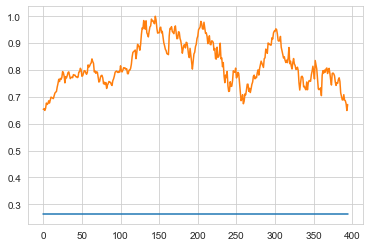

In [178]:
x=[i for i in range(len(x_test))]
plt.plot(x, predictions)
plt.plot(x, y_test)
# plt.imshow()

In [179]:
scaler=MinMaxScaler(feature_range=(0,1))
rf_feature = rf.feature_importances_
rf_feature = scaler.fit_transform(rf_feature.reshape(-1, 1))
rf_feature

array([[5.45286957e-05],
       [2.22141861e-05],
       [2.57467675e-05],
       [7.91078179e-05],
       [1.44216118e-05],
       [0.00000000e+00],
       [1.65323386e-05],
       [2.75101666e-04],
       [2.24691265e-04],
       [9.75943243e-06],
       [3.86379758e-04],
       [3.25123912e-04],
       [2.41320853e-04],
       [3.97014321e-05],
       [1.90828524e-04],
       [1.93699318e-04],
       [7.29710574e-05],
       [3.16520044e-05],
       [5.41242163e-05],
       [5.88841530e-04],
       [5.98831173e-04],
       [6.61785391e-04],
       [4.70888988e-04],
       [5.15292615e-04],
       [8.38272449e-04],
       [1.16180991e-03],
       [1.64408408e-03],
       [2.13567573e-03],
       [2.37021204e-02],
       [1.00000000e+00]])

In [180]:
reg = GradientBoostingRegressor()
reg.fit(x_train, y_train)
predictions = reg.predict(x_test)
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.57 degrees.


In [181]:
xg_feature = reg.feature_importances_
xg_feature = scaler.fit_transform(xg_feature.reshape(-1, 1))
xg_feature

array([[3.76197370e-05],
       [1.66459064e-04],
       [1.54612526e-05],
       [5.08102356e-04],
       [0.00000000e+00],
       [8.39526606e-04],
       [7.51124356e-05],
       [1.24957935e-04],
       [3.01706649e-04],
       [2.70928473e-05],
       [1.07149119e-03],
       [2.34883303e-05],
       [3.65988332e-05],
       [3.39192476e-05],
       [2.29078014e-05],
       [1.95648574e-04],
       [7.37156046e-05],
       [1.50125684e-04],
       [1.62367236e-04],
       [3.03682449e-05],
       [3.01948325e-04],
       [2.29778515e-03],
       [2.44557183e-05],
       [4.38758243e-03],
       [2.62660301e-03],
       [8.99508067e-04],
       [2.26351398e-03],
       [2.46406326e-02],
       [3.44835056e-03],
       [1.00000000e+00]])

In [182]:
reg = DecisionTreeRegressor(max_depth=1000)
reg.fit(x_train, y_train)
predictions = reg.predict(x_test)
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.55 degrees.


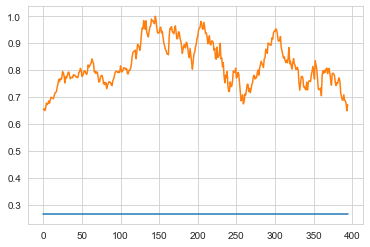

In [183]:
plt.plot(x, predictions)
plt.plot(x, y_test)

In [184]:
reg = RidgeCV()
reg.fit(x_train, y_train)
predictions = reg.predict(x_test)
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.02 degrees.


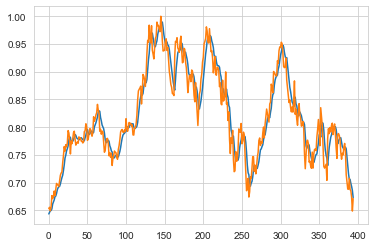

In [185]:
x=[i for i in range(len(x_test))]
plt.plot(x, predictions)
plt.plot(x, y_test)

In [186]:
RidgeCV_feature = reg.coef_
RidgeCV_feature = scaler.fit_transform(RidgeCV_feature.reshape(-1, 1))
RidgeCV_feature

array([[0.03389968],
       [0.02596676],
       [0.04775441],
       [0.02472343],
       [0.02850704],
       [0.0221397 ],
       [0.00466261],
       [0.00306993],
       [0.        ],
       [0.02082963],
       [0.03831968],
       [0.04422398],
       [0.04458266],
       [0.06408936],
       [0.06409586],
       [0.03997558],
       [0.03466461],
       [0.03070265],
       [0.04201401],
       [0.04422385],
       [0.05007278],
       [0.07119281],
       [0.08163254],
       [0.14654778],
       [0.18679449],
       [0.25605055],
       [0.34214488],
       [0.46289246],
       [0.66113259],
       [1.        ]])

In [187]:
reg = LinearRegression()
reg.fit(x_train, y_train)
predictions = reg.predict(x_test)
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.01 degrees.


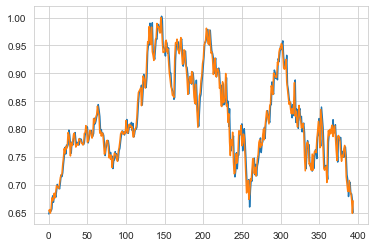

In [188]:
plt.plot(x, predictions)
plt.plot(x, y_test)

In [189]:
LR_feature = reg.coef_
LR_feature = scaler.fit_transform(LR_feature.reshape(-1, 1))
LR_feature

array([[0.17195446],
       [0.02426775],
       [0.24465021],
       [0.07912928],
       [0.12696433],
       [0.17820999],
       [0.09794399],
       [0.14246607],
       [0.10389448],
       [0.09359574],
       [0.15828255],
       [0.15828859],
       [0.07157993],
       [0.16235919],
       [0.17036403],
       [0.1250741 ],
       [0.13839237],
       [0.09960105],
       [0.14756176],
       [0.14281982],
       [0.08143828],
       [0.21820764],
       [0.        ],
       [0.20747127],
       [0.1123951 ],
       [0.14044054],
       [0.16751733],
       [0.16714386],
       [0.06230388],
       [1.        ]])

In [190]:
for i in range(30,0,-1):
    print("Day", i, '&','%.10f' % xg_feature[i-1][0], '&','%.10f' % rf_feature[i-1][0], '&', '%.10f' % LR_feature[i-1][0],'&', '%.10f' % RidgeCV_feature[i-1][0], '\\\\')

Day 30 & 1.0000000000 & 1.0000000000 & 1.0000000000 & 1.0000000000 \\
Day 29 & 0.0034483506 & 0.0237021204 & 0.0623038796 & 0.6611325883 \\
Day 28 & 0.0246406326 & 0.0021356757 & 0.1671438559 & 0.4628924597 \\
Day 27 & 0.0022635140 & 0.0016440841 & 0.1675173304 & 0.3421448774 \\
Day 26 & 0.0008995081 & 0.0011618099 & 0.1404405447 & 0.2560505522 \\
Day 25 & 0.0026266030 & 0.0008382724 & 0.1123950970 & 0.1867944903 \\
Day 24 & 0.0043875824 & 0.0005152926 & 0.2074712732 & 0.1465477793 \\
Day 23 & 0.0000244557 & 0.0004708890 & 0.0000000000 & 0.0816325393 \\
Day 22 & 0.0022977852 & 0.0006617854 & 0.2182076440 & 0.0711928063 \\
Day 21 & 0.0003019483 & 0.0005988312 & 0.0814382835 & 0.0500727849 \\
Day 20 & 0.0000303682 & 0.0005888415 & 0.1428198169 & 0.0442238501 \\
Day 19 & 0.0001623672 & 0.0000541242 & 0.1475617587 & 0.0420140111 \\
Day 18 & 0.0001501257 & 0.0000316520 & 0.0996010546 & 0.0307026506 \\
Day 17 & 0.0000737156 & 0.0000729711 & 0.1383923695 & 0.0346646107 \\
Day 16 & 0.000195648

In [173]:
names=AAPL_df.columns.tolist()
for i in range(len(names)):
    print(names[i], '&', '%.10f' % xg_feature[i-1][0], '&', '%.10f' % rf_feature[i-1][0], '&', '%.10f' %  LR_feature[i-1][0],'&', '%.10f' % RidgeCV_feature[i-1][0], '\\\\')

Date & 0.0001088816 & 0.0003982932 & 0.1668403995 & 0.0909101866 \\
Close & 0.8113933415 & 1.0000000000 & 1.0000000000 & 1.0000000000 \\
Volume & 0.0001270191 & 0.0004105435 & 0.1651664289 & 0.0850668375 \\
Adj Close & 1.0000000000 & 0.8219930297 & 0.4710608238 & 0.9575337816 \\
^DJI_Close & 0.0046094380 & 0.0021109964 & 0.1077034764 & 0.0753307690 \\
^IXIC_Close & 0.0003860128 & 0.0009105062 & 0.0000000000 & 0.1973461366 \\
^GSPC_Close & 0.0001709844 & 0.0024204343 & 0.0567570822 & 0.1628037377 \\
^RLG_Close & 0.0009323724 & 0.0038203917 & 0.4226625451 & 0.2137202982 \\
^NYA_Close & 0.0115676638 & 0.0002927340 & 0.2385439739 & 0.0689802273 \\
^VIX_Close & 0.0001463609 & 0.0002812106 & 0.1768466635 & 0.1016698722 \\
DX-Y.NYB_Close & 0.0000868779 & 0.0002582233 & 0.1668344901 & 0.0842962107 \\
EURUSD=X_Close & 0.0001190478 & 0.0004532431 & 0.1582453346 & 0.0606988301 \\
GBPUSD=X_Close & 0.0002471491 & 0.0003055625 & 0.1692776279 & 0.0876862385 \\
GC=F_Close & 0.0001859754 & 0.0003466176

In [104]:
reg = SVR(kernel='poly')
reg.fit(x_train, y_train)
predictions = reg.predict(x_test)
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 1.58 degrees.


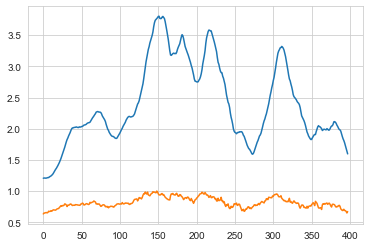

In [92]:
plt.plot(x, predictions)
plt.plot(x, y_test)